In [70]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier

#fetching data
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

### Data pre-processing

In [71]:
underlying = '600789.SS'#鲁抗医药600789.SS
st = '2009-01-01'
et = '2019-01-01'

data = pdr.get_data_yahoo(underlying,st,et)
data = data.dropna()
# data = data .iloc[:,:4]

data['S_10'] = data['Close'].rolling(window=10).mean()
data['RSI'] = ta.RSI(np.array(data['Close']), timeperiod =10)
data['Open-Close'] = data['Open'] -data['Close'].shift(1) #shift(1)向后移动， shift(-1)向前移动  今天-昨天
data['Open-Open'] = data['Open'] - data['Open'].shift(1) #今天的open - 昨天的open
data['MOM']=ta.MOM(data.Close, timeperiod=5)
data['ADX'] = ta.ADX(data.High, data.Low, data.Close, timeperiod=14)
data['ROC'] = ta.ROC(data.Close, timeperiod=10)
data['BETA'] = ta.BETA(data.High, data.Low, timeperiod=5)
data['OBV'] = ta.OBV(data.Close, data.Volume)
data['logReturn'] = np.log(data.Close.shift(-1)/data.Close)

data =data .dropna()
factors =data .columns[-10:-1]
weight = data['Volume']

print(data.head())
print('factors:',factors)

[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close  Adj Close    Volume      S_10  \
Date                                                                            
2009-02-18  3.34615  3.44615  3.24615  3.26154   3.206074  15305222  3.359231   
2009-02-19  3.26923  3.40000  3.26923  3.36154   3.304373  10788501  3.391539   
2009-02-20  3.37692  3.48462  3.30000  3.46154   3.402673  12639426  3.423078   
2009-02-23  3.46154  3.60000  3.42308  3.56154   3.500972  16491625  3.454617   
2009-02-24  3.51538  3.59231  3.35385  3.42308   3.364866  15844775  3.468463   

                  RSI  Open-Close  Open-Open      MOM        ADX        ROC  \
Date                                                                          
2009-02-18  52.996702    -0.07693   -0.23077 -0.17692  49.781485   4.691559   
2009-02-19  58.176269     0.00769   -0.07692 -0.19231  48.108908  10.633020   
2009-02-20  62.738544     0.01538    0.10769 -0

### check imbalance issue

In [72]:
from collections import Counter 
y = np.where(data['logReturn'].shift(-4)>0,1,-1)
c = Counter(y)
dic = dict(c)
print(dic)

print(' the balance ratio of this dataset is :%f\n'%(dic[1]/dic[-1]))

if dic[1]/dic[-1]<4 and dic[1]/dic[-1]>0.25 :
    print('This dataset does not have imbanlance issue' )
else:
    print('This dataset has imbanlance issue' )

{1: 1209, -1: 1194}
 the balance ratio of this dataset is :1.012563

This dataset does not have imbanlance issue


### Random Forest

In [112]:
def get_performance(report,matrix,aoc):    
    index = {'-1','1','macro avg','weighted avg'}
    test_1 = {key:value for key,value in report.items() if key in index}
    report2 = pd.DataFrame(test_1)
    report3 = pd.DataFrame([report['accuracy'],aoc], index=['accuracy','AUC'])
    report4 = pd.DataFrame(matrix,index =['Predicted Positive','Predicted Negative'],columns = ['Actual Positive','Actual Negative'])
    print(report4)
    print('---------------------------------------------------------')
    print(report2)
    print(report3)

def get_roc_curve(roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy',lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend()
    
def tune_parameter(model,par,cv,X_train,y_train):
    parameters = par
    gsearch = GridSearchCV(estimator = model, param_grid = parameters, scoring='roc_auc',cv=cv)
    gsearch.fit(X_train,y_train)

    means = gsearch.cv_results_['mean_test_score']
    params = gsearch.cv_results_['params']

#     for means,params in zip(means,params):
#         print('%f with %r '%(means,params))
    print('the best params is %r with best score is %f'% (gsearch.best_params_, gsearch.best_score_))

In [113]:
X = data[factors]
y = np.where(data['logReturn'].shift(-4)>0,1,-1)  #3天后的涨跌

split = int(0.7*len(data))
X_train,y_train,X_test,y_test = X[:split],y[:split],X[split:-4],y[split:-4]

# Tune parameters by cv
# normal cv
model = RandomForestClassifier(max_features='sqrt')
parameters = {'n_estimators':range(100,201,50),'max_depth':range(5,10,2)}
tune_parameter(model,parameters,5,X_train,y_train)

# # TimeSeriesSplit cv
tscv = TimeSeriesSplit(n_splits=5)
tune_parameter(model,parameters,tscv,X_train,y_train)

# TimeSeriesSplit cv with a fixed training size 
n_splits = 5
tscv_fix = TimeSeriesSplit(n_splits=n_splits,max_train_size= len(X_train) // (n_splits + 1) + len(X_train) % (n_splits + 1) )
tune_parameter(model,parameters,tscv_fix,X_train,y_train)

the best params is {'max_depth': 7, 'n_estimators': 150} with best score is 0.464329
the best params is {'max_depth': 9, 'n_estimators': 200} with best score is 0.528907
the best params is {'max_depth': 5, 'n_estimators': 150} with best score is 0.531950


                    Actual Positive  Actual Negative
Predicted Positive              150              214
Predicted Negative              125              228
---------------------------------------------------------
                   -1           1   macro avg  weighted avg
precision    0.545455    0.515837    0.530646      0.530873
recall       0.412088    0.645892    0.528990      0.527197
f1-score     0.469484    0.573585    0.521534      0.520736
support    364.000000  353.000000  717.000000    717.000000
                 0
accuracy  0.527197
AUC       0.541364
---------------------------------------------------------
Feature importance
OBV           0.125238
BETA          0.119208
RSI           0.117831
Open-Close    0.116924
ADX           0.114867
Open-Open     0.109828
MOM           0.106028
ROC           0.102372
S_10          0.087705
dtype: float64


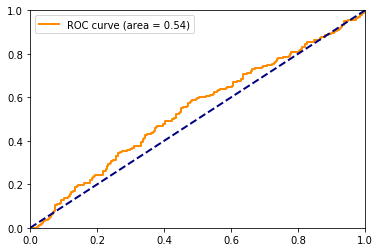

In [87]:
model = RandomForestClassifier(n_estimators=200, max_features='sqrt',max_depth=5)
model.fit(X_train,y_train)
rf_predicted = model.predict(X_test)

#evaluate
con_mat_rf = metrics.confusion_matrix(y_test, rf_predicted)#精确率Precision=a/(a+c)=TP/(TP+FP),召回率recall=a/(a+b)=TP/(TP+FN),
                                                        #准确率accuracy=(a+d)/(a+b+c+d)=(TP+FN+FP+TN)    

mat_df_rf = metrics.classification_report(y_test, rf_predicted,output_dict=True)

#calculate roc_auc
fpr = dict()
tpr = dict()
roc_auc = dict()
rf_scores = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_scores)
roc_auc_rf = auc(fpr, tpr)

#print result
get_performance(mat_df_rf,con_mat_rf,roc_auc_rf)
get_roc_curve(roc_auc_rf)

#feature importance
print('---------------------------------------------------------')
print('Feature importance')
importance = pd.Series(model.feature_importances_,index= factors)
importance = importance.sort_values(ascending = False)
print(importance)

                    Actual Positive  Actual Negative
Predicted Positive              121              243
Predicted Negative              106              247
---------------------------------------------------------
                   -1           1   macro avg  weighted avg
precision    0.533040    0.504082    0.518561      0.518783
recall       0.332418    0.699717    0.516067      0.513250
f1-score     0.409475    0.586002    0.497739      0.496385
support    364.000000  353.000000  717.000000    717.000000
                 0
accuracy  0.513250
AUC       0.530796


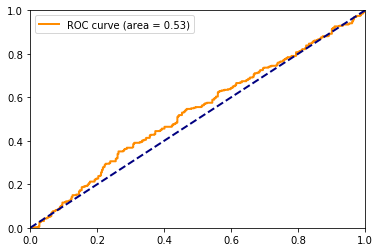

In [77]:
#using volume as sample_weight
weight1 = weight[:split]
model.fit(X_train,y_train,sample_weight=weight1)
rf_predicted = model.predict(X_test)

#evaluate
con_mat = metrics.confusion_matrix(y_test, rf_predicted)#精确率Precision=a/(a+c)=TP/(TP+FP),召回率recall=a/(a+b)=TP/(TP+FN),
                                                        #准确率accuracy=(a+d)/(a+b+c+d)=(TP+FN+FP+TN)    

mat_df = metrics.classification_report(y_test, rf_predicted,output_dict=True)

#calculate roc_auc
fpr = dict()
tpr = dict()
roc_auc = dict()
rf_scores = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_scores)
roc_auc = auc(fpr, tpr)

#print result
get_performance(mat_df,con_mat,roc_auc)
get_roc_curve(roc_auc)

### GBDT

In [114]:
# normal cv
gbc =  GradientBoostingClassifier(max_features='sqrt')
parameters = {'n_estimators':range(100,201,50),'max_depth':range(5,10,2)}
tune_parameter(gbc,parameters,5,X_train,y_train)

# TimeSeriesSplit cv
gbc =  GradientBoostingClassifier(max_features='sqrt')
tscv = TimeSeriesSplit(n_splits=5)
parameters = {'n_estimators':range(100,201,50),'max_depth':range(5,10,2)}
tune_parameter(gbc,parameters,tscv,X_train,y_train)

# TimeSeriesSplit cv with a fixed training size 
gbc =  GradientBoostingClassifier(max_features='sqrt')
n_splits = 5
tscv_fix = TimeSeriesSplit(n_splits=n_splits,max_train_size= len(X_train) // (n_splits + 1) + len(X_train) % (n_splits + 1) )
parameters = {'n_estimators':range(100,201,50),'max_depth':range(5,10,2)}
tune_parameter(gbc,parameters,tscv_fix,X_train,y_train)

the best params is {'max_depth': 9, 'n_estimators': 100} with best score is 0.480220
the best params is {'max_depth': 9, 'n_estimators': 100} with best score is 0.536379
the best params is {'max_depth': 9, 'n_estimators': 200} with best score is 0.540007


                    Actual Positive  Actual Negative
Predicted Positive              139              225
Predicted Negative              144              209
---------------------------------------------------------
                   -1           1   macro avg  weighted avg
precision    0.491166    0.481567    0.486366      0.486440
recall       0.381868    0.592068    0.486968      0.485356
f1-score     0.429675    0.531131    0.480403      0.479625
support    364.000000  353.000000  717.000000    717.000000
                 0
accuracy  0.485356
AUC       0.495509
---------------------------------------------------------
Feature importance:
ADX           0.124039
ROC           0.122760
RSI           0.119620
MOM           0.115542
BETA          0.113147
OBV           0.110723
Open-Open     0.102958
S_10          0.101055
Open-Close    0.090158
dtype: float64


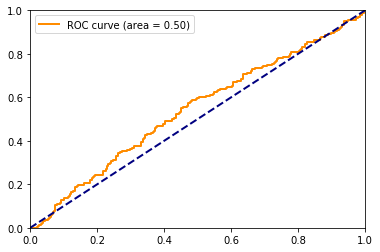

In [116]:
gbc = GradientBoostingClassifier(n_estimators=200,max_depth=9,max_features='sqrt')
gbc.fit(X_train,y_train)
gbc_predicted = gbc.predict(X_test)

#evaluate
con_mat_gbc = metrics.confusion_matrix(y_test, gbc_predicted)   
mat_df_gbc = metrics.classification_report(y_test, gbc_predicted,output_dict=True)

#calculate roc_auc
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
gbc_scores = gbc.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, gbc_scores)
roc_auc_gbc = auc(fpr2, tpr2)

#print result
get_performance(mat_df_gbc,con_mat_gbc,roc_auc_gbc)
get_roc_curve(roc_auc_gbc)

print('---------------------------------------------------------')
print('Feature importance:')
#feature importance
importance2 = pd.Series(gbc.feature_importances_,index= factors)
importance2 = importance2.sort_values(ascending = False)
print(importance2)

                    Actual Positive  Actual Negative
Predicted Positive              141              223
Predicted Negative              143              210
---------------------------------------------------------
                   -1           1   macro avg  weighted avg
precision    0.496479    0.484988    0.490734      0.490822
recall       0.387363    0.594901    0.491132      0.489540
f1-score     0.435185    0.534351    0.484768      0.484007
support    364.000000  353.000000  717.000000    717.000000
                 0
accuracy  0.489540
AUC       0.485275


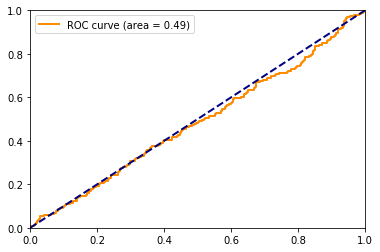

In [117]:
#using volume as sample_weight
weight1 = weight[:split]
gbc.fit(X_train,y_train,sample_weight=weight1)
gbc_predicted = gbc.predict(X_test)

#evaluate
con_mat = metrics.confusion_matrix(y_test, gbc_predicted)#精确率Precision=a/(a+c)=TP/(TP+FP),召回率recall=a/(a+b)=TP/(TP+FN),
                                                        #准确率accuracy=(a+d)/(a+b+c+d)=(TP+FN+FP+TN)    

mat_df = metrics.classification_report(y_test, gbc_predicted,output_dict=True)

#calculate roc_auc
fpr = dict()
tpr = dict()
roc_auc = dict()
gbc_scores = gbc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, gbc_scores)
roc_auc = auc(fpr, tpr)

#print result
get_performance(mat_df,con_mat,roc_auc)
get_roc_curve(roc_auc)

### Comparison

In [118]:
def compare(dic,matrix,aoc):    
    index = {'-1','1','macro avg','weighted avg'}
    test_1 = {key:value for key,value in dic.items() if key in index}
    report2 = pd.DataFrame(test_1)
    r = [dic['accuracy'],report2.iat[0,3],report2.iat[1,3],report2.iat[2,3],aoc]
    return r

result_rf = compare(mat_df_rf,con_mat_rf,roc_auc_rf)
result_gbc = compare(mat_df_gbc,con_mat_gbc,roc_auc_gbc)

result = pd.DataFrame(columns=['accuracy','precision','recall','f1-score','AUC'],index=['rf','gbc'])
for i in range(len(result_rf)):
    result.iat[0,i]=result_rf[i]
    result.iat[1,i]=result_gbc[i]

print(result)
print('--------------------------------------------------')
print(result.mean(axis = 1))

     accuracy precision    recall  f1-score       AUC
rf   0.527197  0.530873  0.527197  0.520736  0.541364
gbc  0.485356   0.48644  0.485356  0.479625  0.495509
--------------------------------------------------
rf     0.529473
gbc    0.486457
dtype: float64


### Conclusion
Random Forest performs the best for my dataset (daily, 600789.SS, from 20090101 to 20190101) with accuracy=0.527197, precision = 0.530873, recall = 0.527197, f1-score = 0.520736, AUC = 0.541364.